In [38]:
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np
import torch.optim as optim
import textwrap
from tqdm import tqdm
import math
import textwrap
from matplotlib import pyplot as plt
from process_eicu import get_eicu_dataset
import importlib
import DeePJ
import train
import utils
importlib.reload(DeePJ)
importlib.reload(train)
importlib.reload(utils)

<module 'utils' from '/Users/deyili/Documents_Local/BMI_PhD@UF/Projects/AKI_Graph_Transformer/eICU_all/utils.py'>

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using mps
Using device: mps


In [3]:
# TensorDataset(all_pat_id, all_code_ints, all_pad_masks, all_causal_masks, all_intervals, prior_matrices, all_labels)
dataset, enc_dict, pat_dict, all_str2int, pat_id_mapping = get_eicu_dataset('./eicu_full/', 777)

Total encounter: 200859
duration_cut: 132783
dup_cut: 0
Finish processing encounters


626858it [00:00, 747473.14it/s]


Diagnoses without encounter id: 450589


2710672it [00:03, 866609.21it/s]


Diagnoses without encounter id: 2483092
Finish processing diagnoses


3688745it [00:03, 982482.13it/s]


Treatment without encounter id: 3372000
Finish processing treatments
Number of encounters: 41026
Average number of dx: 6.462268
Average number of px: 5.026276
Min dx cut: 16670
Min px cut: 10373
Max dx cut: 1
Max px cut: 6
Proportion of expired: 0.072710
Entire vocabulary size: 5457
Number of patients: 39874
Average number of encounters per patient: 1.028891
Proportion of expired: 0.074811
Finish constructing PatientInfo


100%|██████████| 39874/39874 [00:02<00:00, 14778.72it/s]


Finish adding conditional probabilities


In [4]:
# show some stastistics
labels = []
max_elapsed_time = 0
for pat in dataset:
    labels.append(pat[-1].item())
    elapsed_time = pat[4][-1].item()
    if elapsed_time > max_elapsed_time:
        max_elapsed_time = elapsed_time

num_samples = len(dataset)
print(f'num_samples: {num_samples}')        
print(f'max_elapsed_time: {max_elapsed_time} minutes')
num_classes = np.unique(np.array(labels)).size
print(f'num_classes: {num_classes}')
# get the pad token
pad_token = len(all_str2int)
print(f'pad_token: {pad_token}')
# add 1 to vocab size for the pad token
vocab_size = len(all_str2int) + 1
print(f'vocab_size: {vocab_size}')
seq_len = len(dataset[0][1])
print(f'seq_len: {seq_len}')
max_num_encs = list(pat_dict.values())[0].max_num_encs
print(f'max_num_encs: {max_num_encs}')
max_num_codes = 50
print(f'max_num_codes: {max_num_codes}')

num_samples: 39874
max_elapsed_time: 78468 minutes
num_classes: 2
pad_token: 5457
vocab_size: 5458
seq_len: 200
max_num_encs: 2
max_num_codes: 50


In [5]:
hp_dict = {
    # common model hyper-parameters
    'vocab_size': vocab_size,
    'd_model': 256,
    'num_encoder_layers': 3,
    'dropout': 0.5,
    'num_classifier_layers': 1,
    'num_classes': num_classes,
    # gct hyper-parameters
    'GCT_KLD_coef': 1.0,
    # deepj hyper-parameters
    'max_elapsed_time': max_elapsed_time,
    'num_deepj_graph_clusters': 3,
    'deepj_KLD_coef': 1.0,
    'deepj_link_coef': 1.0,
    'deepj_ent_coef': 1.0,
    # gnn hyper-parameters
    'num_gnn_layers': 5,
    # training hyper-parameters
    'batch_size': 256,
    'epochs': 20,
    'lr': 5e-4,
    'scheduler_step': 8,
    'scheduler_rate': 0.8,
    'weight_decay': 1e-3,
}

In [6]:
deepj = DeePJ.make_deepj_model(hp_dict['d_model'], hp_dict['num_encoder_layers'], hp_dict['num_classifier_layers'], 
                                   hp_dict['dropout'], hp_dict['vocab_size'], hp_dict['max_elapsed_time'], hp_dict['num_deepj_graph_clusters'],
                                   hp_dict['num_classes']).to(device)
model_dict = {'deepj': deepj}

In [7]:
dataset_size = len(dataset)
indices = np.arange(dataset_size)
# Split into train (70%) and temp (30%)
train_idx, temp_idx = train_test_split(indices, test_size=0.7, random_state=42, shuffle=True)
# Split temp into validation (10%) and test (20%)
val_idx, test_idx = train_test_split(temp_idx, test_size=2/3, random_state=42, shuffle=True)
# Create DataLoaders
train_loader = DataLoader(Subset(dataset, train_idx), batch_size=hp_dict['batch_size'], shuffle=True)
val_loader = DataLoader(Subset(dataset, val_idx), batch_size=hp_dict['batch_size'], shuffle=False)
test_loader = DataLoader(Subset(dataset, test_idx), batch_size=hp_dict['batch_size'], shuffle=False)

In [8]:
optimizer_dict = {'deepj': torch.optim.Adam(model_dict['deepj'].parameters(), lr=hp_dict['lr'], weight_decay=hp_dict['weight_decay'])}
scheduler_dict = {'deepj': optim.lr_scheduler.StepLR(optimizer_dict['deepj'], step_size=hp_dict['scheduler_step'], gamma=hp_dict['scheduler_rate'])}

In [9]:
best_model_dict = train.train(model_dict, train_loader, val_loader, optimizer_dict, scheduler_dict, hp_dict, device)

	Epoch 1/20
	deepj, Loss: 0.5016, LR: 0.000500
		On train set - Accuracy: 0.9377, Precision: 0.7945, Recall: 0.6953, F1 Score: 0.7326, AUROC: 0.8197, AUPRC: 0.4884
		On val set - Accuracy: 0.9353, Precision: 0.7702, Recall: 0.6974, F1 Score: 0.7268, AUROC: 0.8063, AUPRC: 0.4665
	Epoch 2/20
	deepj, Loss: 0.3209, LR: 0.000500
		On train set - Accuracy: 0.9432, Precision: 0.8193, Recall: 0.7231, F1 Score: 0.7608, AUROC: 0.8878, AUPRC: 0.5724
		On val set - Accuracy: 0.9398, Precision: 0.7922, Recall: 0.7159, F1 Score: 0.7470, AUROC: 0.8503, AUPRC: 0.5240
	Epoch 3/20
	deepj, Loss: 0.2931, LR: 0.000500
		On train set - Accuracy: 0.9453, Precision: 0.8280, Recall: 0.7355, F1 Score: 0.7725, AUROC: 0.9075, AUPRC: 0.6126
		On val set - Accuracy: 0.9397, Precision: 0.7904, Recall: 0.7199, F1 Score: 0.7492, AUROC: 0.8605, AUPRC: 0.5388
	Epoch 4/20
	deepj, Loss: 0.2829, LR: 0.000500
		On train set - Accuracy: 0.9473, Precision: 0.8321, Recall: 0.7534, F1 Score: 0.7863, AUROC: 0.9227, AUPRC: 0.6358

# Graph Visualization

In [10]:
all_int2str = {
    value: '|'.join(key.split('|')[-2:])  # Join the last two parts with '|'
    for key, value in all_str2int.items()
}

In [11]:
# shorten the all_int2str
all_int2str_short = {}
for k, v in all_int2str.items():
    if len(v) < 50:
        short_v = v
    elif v == 'was the patient admitted from the o.r. or went to the o.r. within 4 hours of admission?|no':
        short_v = "No ICU admission within 4 hours"  
    elif v == 'was the patient admitted from the o.r. or went to the o.r. within 4 hours of admission?|yes':
        short_v = "Recent ICU admission within 4 hours"  
    else:
        last = v.split('|')[-1]
        if last == 'no' or last == 'yes':
            short_v = v
        else:
            short_v = last
    all_int2str_short[k] = short_v

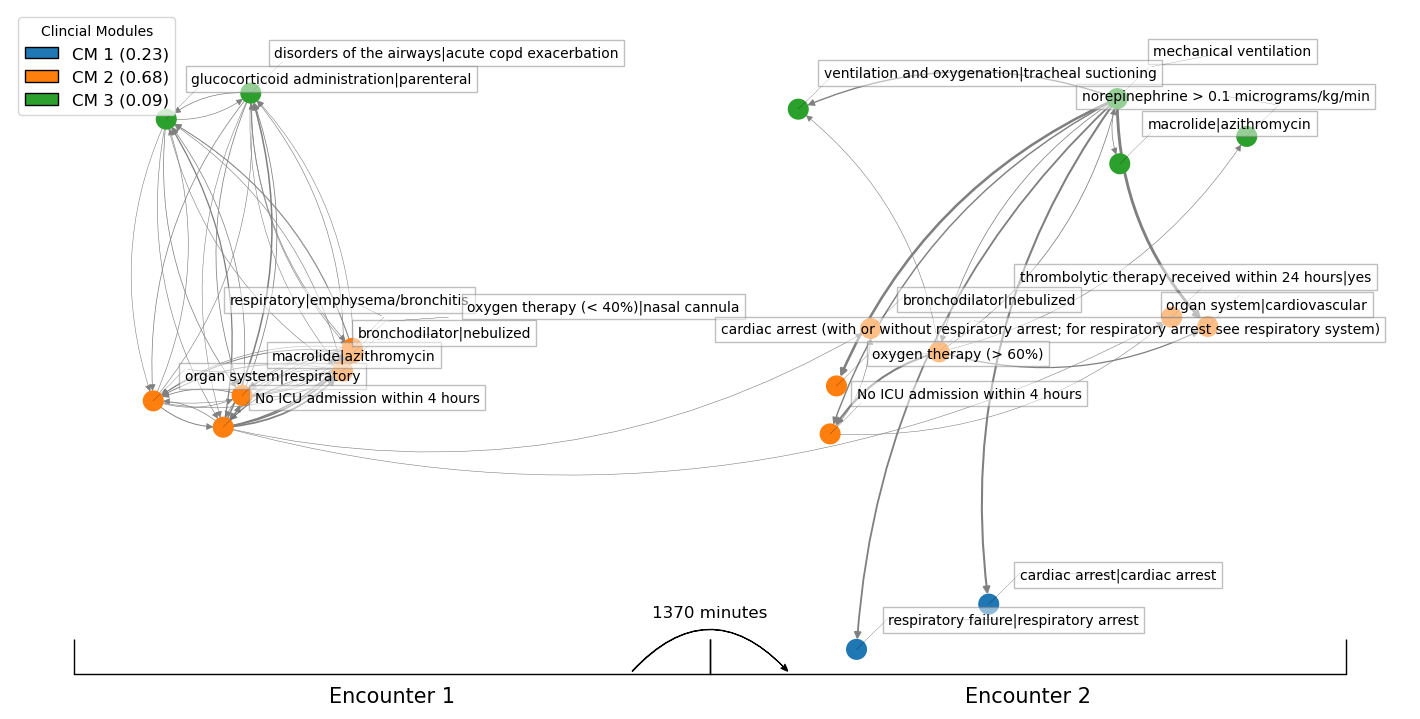

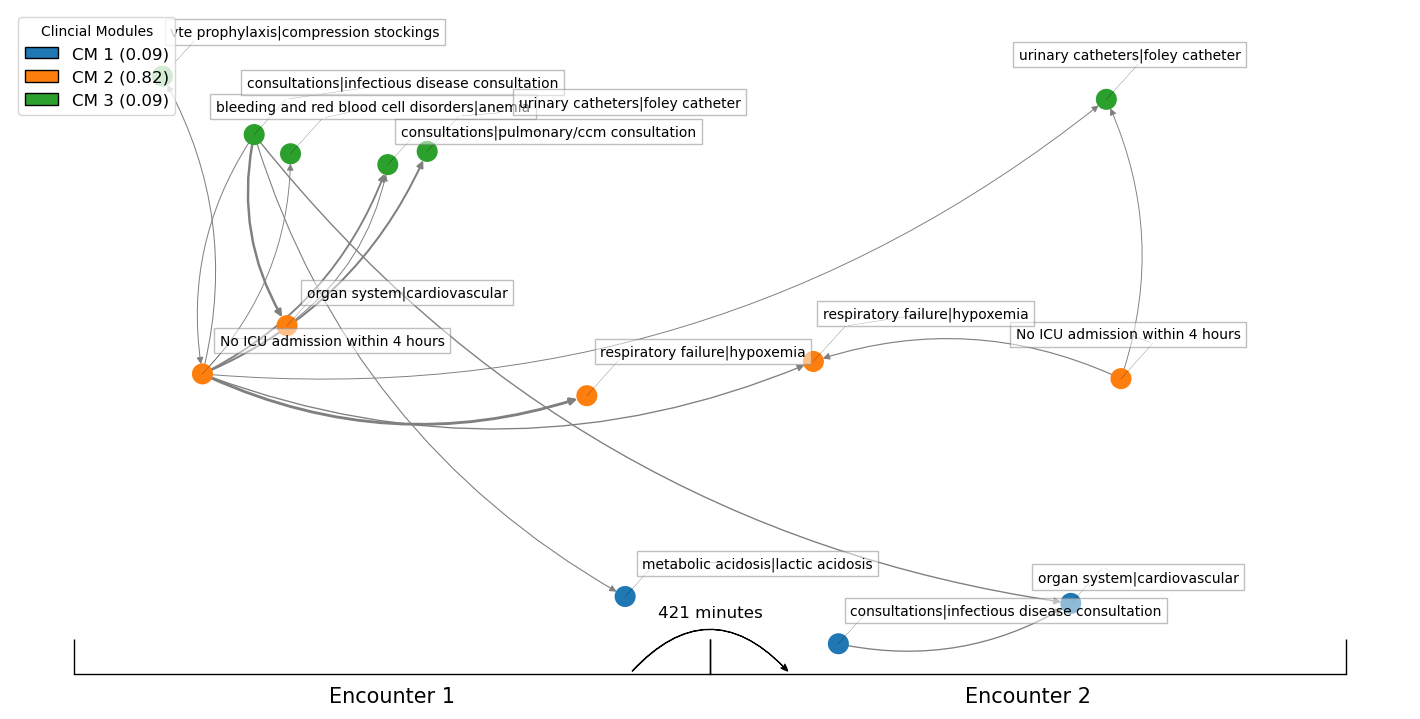

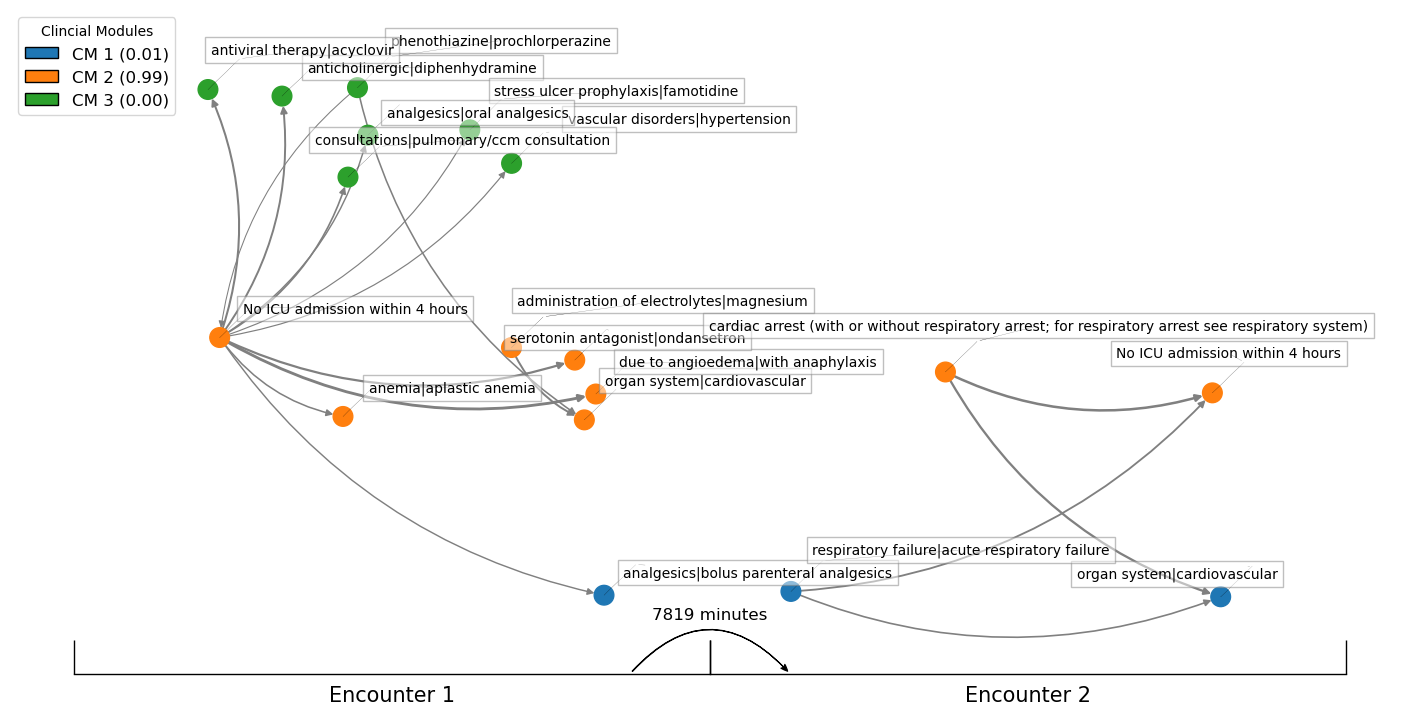

In [12]:
best_model = best_model_dict['deepj'].to('cpu')
count = 0
for sample in dataset:
    pat_id, code_ints, pad_masks, causal_masks, intervals, prior_matrices, labels = sample
    # we only plot the graphs of the patients whose have more than 2 encounters
    if intervals[-1] != 0 and labels.item() == 1:
        with torch.no_grad():
            _, adj_matrices, cluster_assign, cluster_weights, _, _, _ = best_model(code_ints.unsqueeze(0), 
                                                                                pad_masks.unsqueeze(0), 
                                                                                causal_masks.unsqueeze(0), 
                                                                                intervals.unsqueeze(0), 
                                                                                prior_matrices.unsqueeze(0))
        adj_matrix = adj_matrices[0].detach().numpy()
        cluster_hard = cluster_assign.argmax(dim=-1)[0].detach().numpy()
        
        utils.plot_graph(adj_matrix, intervals, cluster_hard, cluster_weights, all_int2str_short, 0.1, code_ints)
        count += 1
    if count == 3:
        break

# Edge Statistics

In [13]:
expired_patients = []
# we only need expried patients
for sample in dataset:
    pat_id, code_ints, pad_masks, causal_masks, intervals, prior_matrices, labels = sample
    if labels.item() == 1:
        expired_patients.append(sample)
print(len(expired_patients))

2983


In [14]:
def get_edges_above_threshold(adj_matrix, threshold):
    """
    Find the coordinates and values of all entries in an array (NumPy or PyTorch)
    that are greater than the given threshold.

    Parameters:
    - adj_matrix (numpy.ndarray or torch.Tensor): Input adjacency matrix (NumPy or PyTorch tensor).
    - threshold (float): Threshold value.

    Returns:
    - list of tuples: [((row, col), value)] where value > threshold.
    """
    # Convert PyTorch tensor to NumPy if necessary
    if isinstance(adj_matrix, torch.Tensor):
        adj_matrix = adj_matrix.cpu().numpy()

    # Find coordinates where values exceed the threshold
    coordinates = np.argwhere(adj_matrix > threshold)

    # Store ((row, col), value) pairs
    coordinates = [((int(row), int(col)), float(adj_matrix[row, col])) for row, col in coordinates]

    return coordinates

In [15]:
def intra_enc_check(coordinates, max_num_codes):
    # filter out those inter-encounter connections
    cleaned_coordinates = []
    for corr in coordinates:
        if (corr[0][0] // (max_num_codes * 2)) == (corr[0][1] // (max_num_codes * 2)):
            cleaned_coordinates.append(corr)
    return cleaned_coordinates

In [16]:
def inter_enc_check(coordinates, max_num_codes):
    # filter out those intra-encounter connections
    cleaned_coordinates = []
    for corr in coordinates:
        if (corr[0][0] // (max_num_codes * 2)) != (corr[0][1] // (max_num_codes * 2)):
            cleaned_coordinates.append(corr)
    return cleaned_coordinates

In [17]:
def translate_coors_to_ints(coordinates, code_ints, pad_token):
    if isinstance(code_ints, torch.Tensor):
        code_ints = code_ints.cpu().numpy()
    translated_coordinates = []
    for coor in coordinates:
        translated_coordinates.append(((code_ints[coor[0][0]], code_ints[coor[0][1]]), coor[1]))
    # sanity check
    for coor in translated_coordinates:
        assert coor[0][0] != pad_token and coor[0][1] != pad_token
    return translated_coordinates

In [18]:
def enc_edge_dict_update(coordinates, enc_edge_dict):
    for coor in coordinates:
        if coor[0] not in enc_edge_dict.keys():
            enc_edge_dict[coor[0]] = []
        enc_edge_dict[coor[0]].append(coor[1])
    return enc_edge_dict

In [19]:
intra_enc_edge_dict = {}
inter_enc_edge_dict = {}
for sample in tqdm(expired_patients):
    _, code_ints, pad_masks, causal_masks, intervals, prior_matrices, labels = sample
    with torch.no_grad():
        _, adj_matrices, cluster_assign, cluster_weights, _, _, _ = best_model(code_ints.unsqueeze(0), 
                                                                            pad_masks.unsqueeze(0), 
                                                                            causal_masks.unsqueeze(0), 
                                                                            intervals.unsqueeze(0), 
                                                                            prior_matrices.unsqueeze(0))
    coordinates = get_edges_above_threshold(adj_matrices[0], 0.1)
    intra_cleaned_coordinates = intra_enc_check(coordinates, max_num_codes)
    inter_cleaned_coordinates = inter_enc_check(coordinates, max_num_codes)
    intra_translated_coordinates = translate_coors_to_ints(intra_cleaned_coordinates, code_ints, pad_token)
    inter_translated_coordinates = translate_coors_to_ints(inter_cleaned_coordinates, code_ints, pad_token)
    intra_enc_edge_dict = enc_edge_dict_update(intra_translated_coordinates, intra_enc_edge_dict)
    inter_enc_edge_dict = enc_edge_dict_update(inter_translated_coordinates, inter_enc_edge_dict)

100%|██████████| 2983/2983 [00:09<00:00, 305.64it/s]


In [20]:
# count unique encounters and encounter gaps
# that is, each patient can have 1 to max_num_encs unique encounters and max_num_encs - 1 encounter gaps
num_unq_encs = 0
num_enc_gaps = 0
for sample in tqdm(expired_patients):
    pat_id, code_ints, pad_masks, causal_masks, intervals, prior_matrices, labels = sample
    if intervals[-1] != 0:
        num_unq_encs += 2
        num_enc_gaps += 1
    else:
        num_unq_encs += 1
        num_enc_gaps += 0

100%|██████████| 2983/2983 [00:00<00:00, 355241.59it/s]


In [21]:
def translate_codes_to_strings(top_10_dict, all_int2str):
    top_10_dict_translated = dict()
    for key, values in top_10_dict.items():
        code_1 = all_int2str[key[0]]
        code_2 = all_int2str[key[1]]
        top_10_dict_translated[(code_1, code_2)] = values
    return top_10_dict_translated

In [22]:
def process_enc_edge_dict(enc_edge_dict, enc_count, all_int2str, top_n):
    """
    Processes enc_edge_dict to compute 'pct', 'mean', and 'std' for each key.
    Keeps only the top 10 key-value pairs with the highest 'pct'.

    Parameters:
    - enc_edge_dict (dict): Dictionary where keys are (node_i, node_j) tuples, 
                            and values are lists of float numbers.
    - enc_count (int): Total number of encoding counts.

    Returns:
    - dict: Processed dictionary with top 10 (node_i, node_j) pairs by 'pct'.
    """
    processed_dict = {}

    # Compute pct, mean, std for each key
    for key, values in enc_edge_dict.items():
        pct = len(values) / enc_count
        mean = np.mean(values)
        std = np.std(values)
        
        processed_dict[key] = {'pct': pct, 'mean': mean, 'std': std}

    # Sort by 'pct' in descending order and keep only the top 10
    top_n_dict = dict(sorted(processed_dict.items(), key=lambda x: x[1]['pct'], reverse=True)[:top_n])
    
    # translate the keys to strings
    top_n_dict = translate_codes_to_strings(top_n_dict, all_int2str)

    return top_n_dict

In [23]:
top_intra_enc_edge_dict = process_enc_edge_dict(intra_enc_edge_dict, num_unq_encs, all_int2str_short, 8)
top_inter_enc_edge_dict = process_enc_edge_dict(inter_enc_edge_dict, num_enc_gaps, all_int2str_short, 8)

In [24]:
def wrap_label(label, max_length=50, wrap_at=25):
    """
    Truncate label to max_length and wrap into multiple lines if needed.

    Parameters:
    - label (str): The text label.
    - max_length (int): Maximum character length before truncating.
    - wrap_at (int): Number of characters per line for wrapping.

    Returns:
    - str: Wrapped text with line breaks.
    """
    label = label.split("|")[-1]  # Keep only the last part after '|'
    if len(label) > max_length:
        label = label[:max_length] + "..."
    return "\n".join(textwrap.wrap(label, wrap_at))  # Wrap at spaces

def plot_enc_edge_data(ax, data, title="Mean and Standard Deviation of Conditions"):
    """
    Plots mean values with standard deviation error bars for given condition pairs.

    Parameters:
    - ax (matplotlib.axes.Axes): The axis object where the plot will be drawn.
    - data (dict): Dictionary with keys as (condition_1, condition_2) and values as:
      {'pct': float, 'mean': float, 'std': float}
    - title (str): Title of the subplot.
    """
    # Sort data by 'pct' in descending order
    sorted_data = sorted(data.items(), key=lambda x: x[1]['pct'], reverse=True)

    # Extract labels and values
    labels = [
        f"{wrap_label(k[1])} →\n{wrap_label(k[0])} ({v['pct'] * 100:.2f}%)"
        for k, v in sorted_data
    ]
    means = [v['mean'] for k, v in sorted_data]  # X-axis mean values
    std_devs = [v['std'] for k, v in sorted_data]  # Error bars (std)

    # Y-axis positions
    y_pos = np.arange(len(labels))

    # Plot mean as blue dots
    ax.scatter(means, y_pos, color='blue', label='Mean')

    # Plot error bars (std deviation)
    ax.errorbar(means, y_pos, xerr=std_devs, fmt='o', color='black', capsize=3)

    # Formatting
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=16)
    ax.set_xlabel("Edge weight")
    ax.set_title(title, fontsize=18)
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.invert_yaxis()  # Highest pct at the top

In [25]:
# shorten the labels
code_name_short_map = {
    "mechanical ventilation": "Mechanical ventilation",
    "organ system|cardiovascular": "Cardiovascular",
    "respiratory failure|acute respiratory failure": "Acute respiratory failure",
    "respiratory failure|hypoxemia": "Hypoxemia",
    "arrest, respiratory (without cardiac arrest)": "Respiratory arrest",
    "cardiac arrest (with or without respiratory arrest; for respiratory arrest see respiratory system)": "Cardiac arrest",
    "norepinephrine > 0.1 micrograms/kg/min": "Norepinephrine",
    
}

top_intra_enc_edge_dict_short = {}
top_inter_enc_edge_dict_short = {}
for edge in top_intra_enc_edge_dict.keys():
    node_1 = edge[0]
    node_2 = edge[1]
    if node_1 in code_name_short_map.keys():
        node_1 = code_name_short_map[node_1]
    if node_2 in code_name_short_map.keys():
        node_2 = code_name_short_map[node_2]
    top_intra_enc_edge_dict_short[(node_1, node_2)] = top_intra_enc_edge_dict[edge]
for edge in top_inter_enc_edge_dict.keys():
    node_1 = edge[0]
    node_2 = edge[1]
    if node_1 in code_name_short_map.keys():
        node_1 = code_name_short_map[node_1]
    if node_2 in code_name_short_map.keys():
        node_2 = code_name_short_map[node_2]
    top_inter_enc_edge_dict_short[(node_1, node_2)] = top_inter_enc_edge_dict[edge]
        

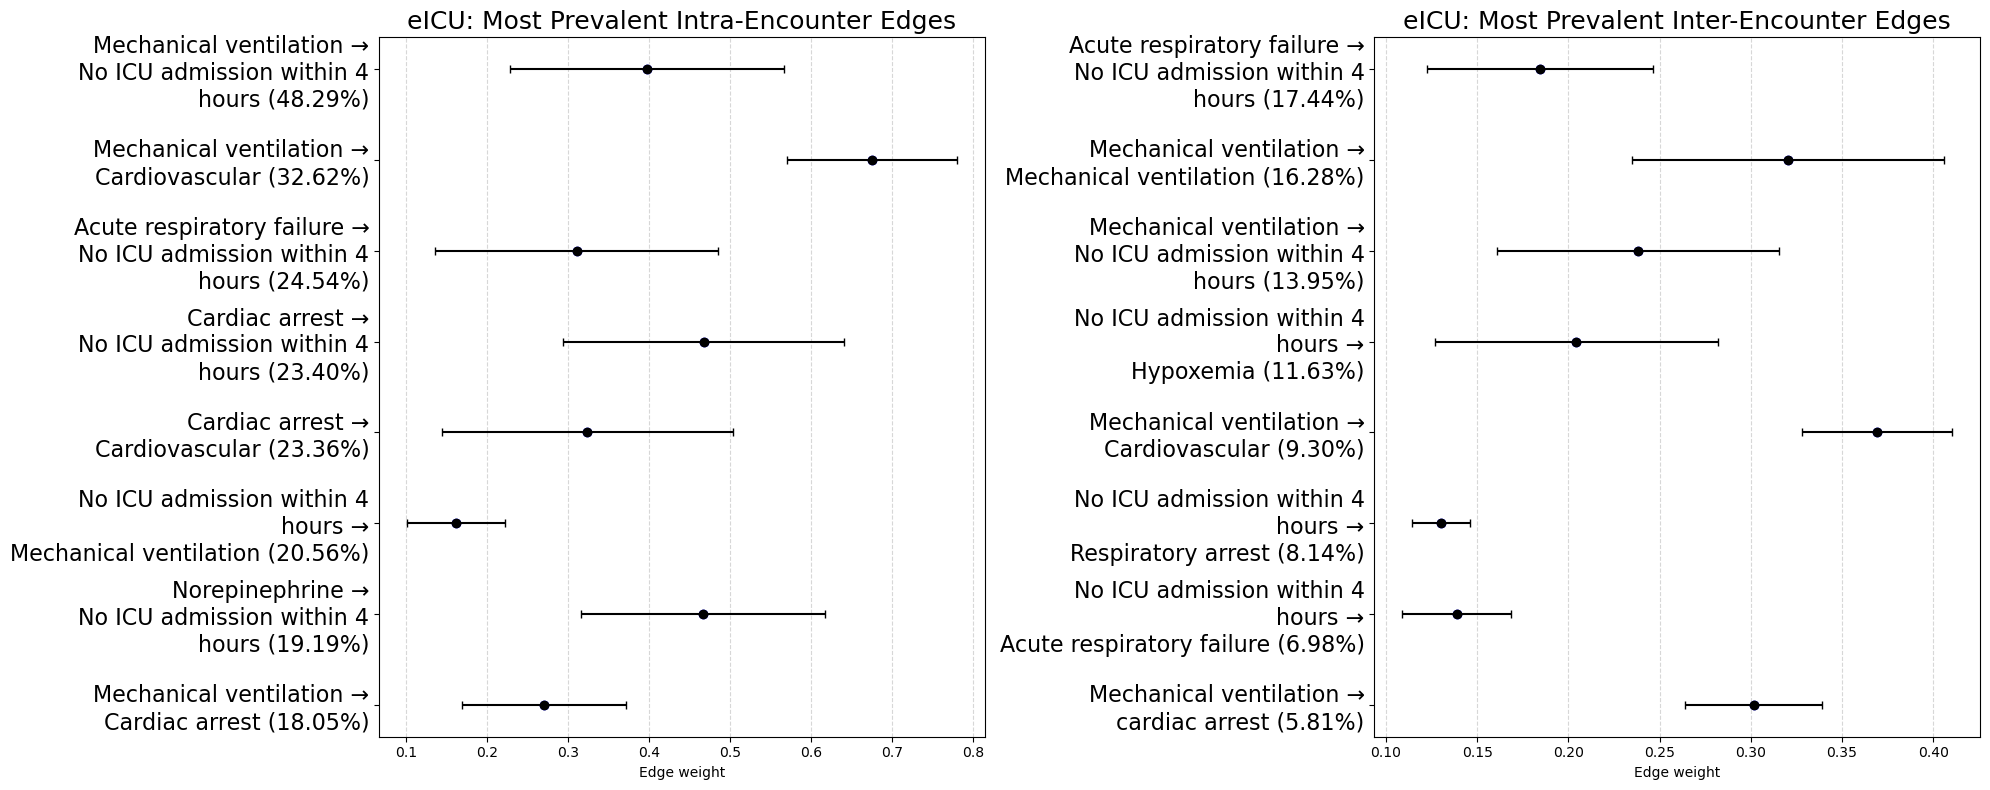

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Creating subplots
plot_enc_edge_data(axes[0], top_intra_enc_edge_dict_short, title="eICU: Most Prevalent Intra-Encounter Edges")
plot_enc_edge_data(axes[1], top_inter_enc_edge_dict_short, title="eICU: Most Prevalent Inter-Encounter Edges")
plt.tight_layout()
plt.show()
fig.savefig('./eicu_edge_weights.tiff', dpi=300, bbox_inches='tight')

# Clincial Module Statistics

The visualization strategy here is that we choose some common dx and px code in ICU and see what codes are the most co-occuring with them

In [27]:
analyse_codes = [3, 4, 233, 5]
analyse_codes_count = {code: 0 for code in analyse_codes}
same_cluster_codes = {code: {} for code in analyse_codes}

for sample in tqdm(dataset):
    pat_id, code_ints, pad_masks, causal_masks, intervals, prior_matrices, labels = sample
    with torch.no_grad():
        _, adj_matrices, cluster_assign, cluster_weights, _, _, _ = best_model(
            code_ints.unsqueeze(0), 
            pad_masks.unsqueeze(0), 
            causal_masks.unsqueeze(0), 
            intervals.unsqueeze(0), 
            prior_matrices.unsqueeze(0)
        )
    code_ints = code_ints.detach().numpy()
    cluster_hard = cluster_assign.argmax(dim=-1)[0].detach().numpy()

    for code in analyse_codes:
        if code in code_ints:
            # Increment count for the code
            analyse_codes_count[code] += 1

            # Find all indices where code appears
            code_indices = np.where(code_ints == code)[0]
            
            # Find the corresponding clusters
            code_clusters = cluster_hard[code_indices]

            # Find all codes in the same clusters
            for cluster in np.unique(code_clusters):
                cluster_codes = code_ints[np.where(cluster_hard == cluster)[0]]
                
                # Update same_cluster_codes dictionary
                for cluster_code in set(cluster_codes):
                    if cluster_code != code and cluster_code != pad_token:
                        if cluster_code not in same_cluster_codes[code]:
                            same_cluster_codes[code][cluster_code] = 0
                        same_cluster_codes[code][cluster_code] += 1          

100%|██████████| 39874/39874 [02:00<00:00, 330.64it/s]


In [28]:
# Step 1: Convert co-occurrence counts to percentages
for code in same_cluster_codes:
    if analyse_codes_count[code] > 0:
        for co_code in same_cluster_codes[code]:
            same_cluster_codes[code][co_code] /= analyse_codes_count[code]  # Normalize to percentage


In [29]:
# Step 2: Keep only the top 5 co-occurring codes for each analyse_code
for code in same_cluster_codes:
    sorted_codes = sorted(same_cluster_codes[code].items(), key=lambda x: x[1], reverse=True)  # Sort by percentage
    same_cluster_codes[code] = dict(sorted_codes[:5])  # Keep only top 5

In [30]:
# step 3: translate the codes to strings
translated_same_cluster_codes = {}
for analyse_code, co_codes in same_cluster_codes.items():
    translated_same_cluster_codes[all_int2str_short[analyse_code]] = {
        all_int2str_short[co_code]: percentage
        for co_code, percentage in co_codes.items()
    }

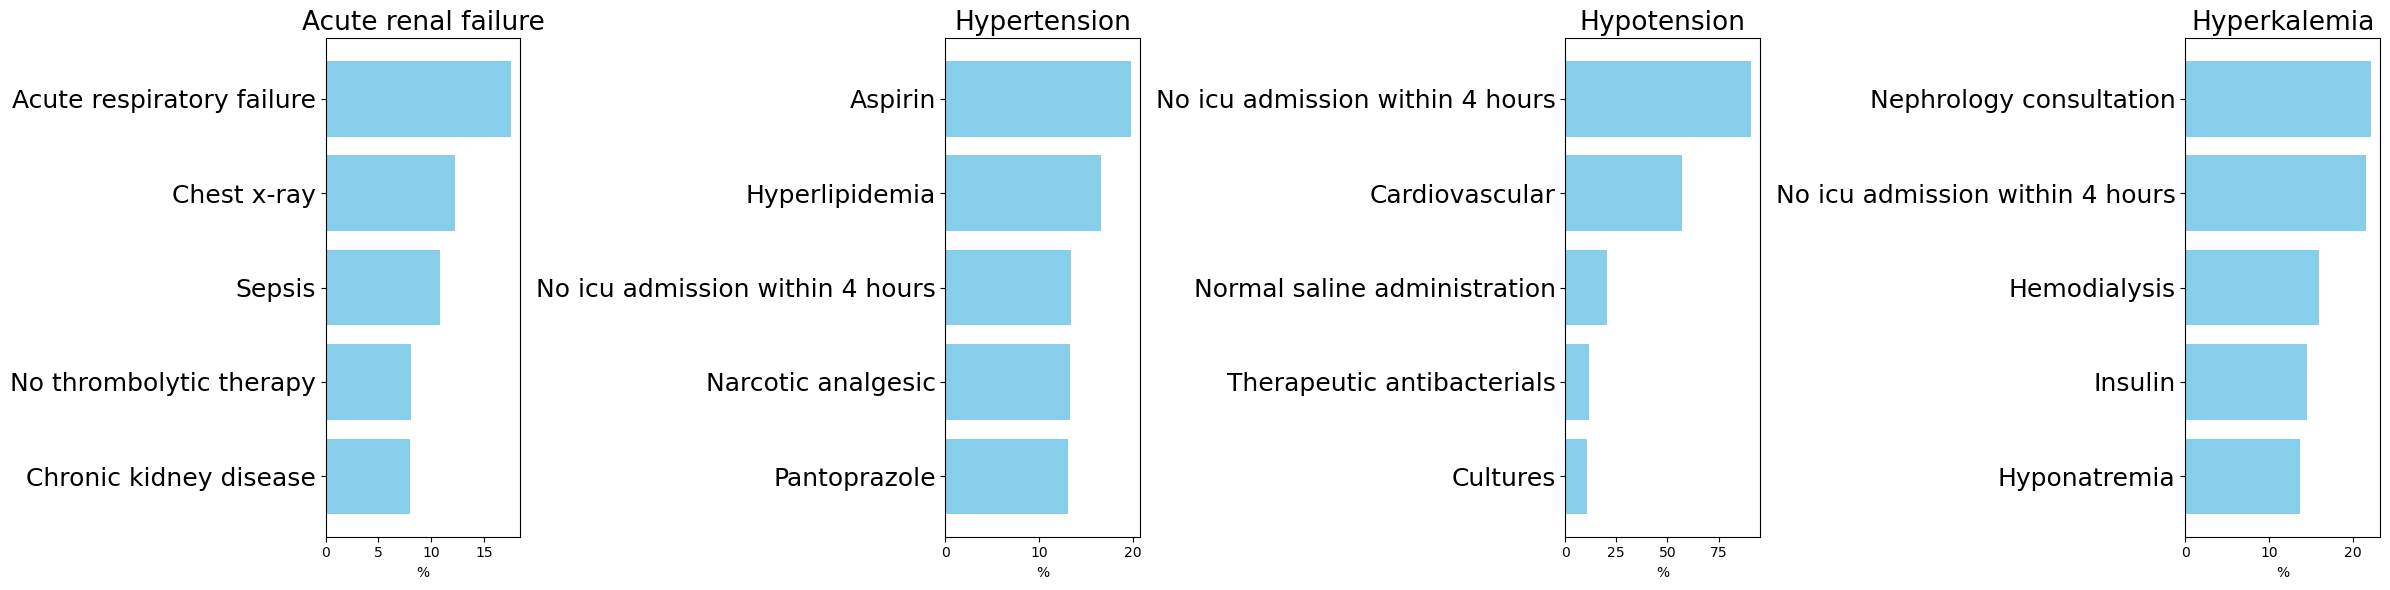

In [47]:
def format_y_label(label):
    parts = label.split("|")
    if parts[-1].strip().lower() == "no":  # If last part is "no", prepend "No" to the second last part
        shortened =  "No " + parts[-2].strip().capitalize() if len(parts) > 1 else "No"
    else:
        shortened = parts[-1].strip().capitalize()  # Otherwise, capitalize the last part
    
    if shortened == "No Thrombolytic therapy received within 24 hours":
        shortened = "No thrombolytic therapy"
    return shortened 


# Determine the number of rows and columns for subplots
num_codes = len(translated_same_cluster_codes)
num_cols = 4  # Fixed number of columns per row
num_rows = math.ceil(num_codes / num_cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 6))  # Adjust figure size

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plot each analyse_code
for i, (code, co_codes_dict) in enumerate(translated_same_cluster_codes.items()):
    co_codes = [format_y_label(c) for c in co_codes_dict.keys()]  # Format y labels
    percentages = [value * 100 for value in co_codes_dict.values()]  # Convert to percentages

    axes[i].barh(co_codes, percentages, color='skyblue')  # Use horizontal bars for better readability
    axes[i].set_xlabel("%")  # Label x-axis
    axes[i].set_title(f"{code.split('|')[-1].capitalize()}", fontsize=19)  # Set title as analyse_code
    axes[i].invert_yaxis()  # Invert y-axis for better readability
    axes[i].tick_params(axis='y', labelsize=18)  # Enlarge y-axis labels
    

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
# Adjust layout
plt.tight_layout()
plt.savefig('./eicu_top5_cooccurrence.tiff', dpi=300, bbox_inches='tight')
plt.show()